In [ ]:
#@title Import the competition dataset
from pathlib import Path
import os

creds = '{"username":"sebasmanco","key":"a0f01aadb0e584b9c9aa0e8ebf5a2696"}'                        # credentials for kaggle APi

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    path = Path('../input/titanic')
    !pip install -Uqq fastai
else:
    import zipfile,kaggle
    path = Path('titanic')
    if not path.exists():
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 34.1k/34.1k [00:00<00:00, 30.9MB/s]

# Random forests

## Binary splits

In [ ]:
# import of the immportant libraries like numpy, pandas etc
from fastai.imports import *
np.set_printoptions(linewidth=130)
%config InlineBackend.figure_format = 'retina'

In [ ]:
df = pd.read_csv(path/'train.csv')
tst_df = pd.read_csv(path/'test.csv')
modes = df.mode().iloc[0]

df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


For random forests we dont have to create dummy variables, instead, we can just convert those fields to categorical variables, this is, pandas makes a list with all the unique valuees in the column and then replace each value with a number.

In [ ]:
def proc_data(df):
    df['Fare'] = df.Fare.fillna(0)
    df.fillna(modes, inplace=True)
    df['LogFare'] = np.log1p(df['Fare'])
    df['Embarked'] = pd.Categorical(df.Embarked)
    df['Sex'] = pd.Categorical(df.Sex)

proc_data(df)
proc_data(tst_df)

miaking a list with the continous, categorical and dependent variables:

In [ ]:
cats=["Sex","Embarked"]
conts=['Age', 'SibSp', 'Parch', 'LogFare',"Pclass"]
dep="Survived"

In [ ]:
df.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: category
Categories (2, object): ['female', 'male']

In [ ]:
df.Sex.cat.codes.head()

0    1
1    0
2    0
3    0
4    1
dtype: int8

A binary split is an object where we can split tour columns into two groups according to a specific threshold of some column, this is, if the value of the row is above or below this threshold.

for exmaple, for the variable sex (that is `0` and `1`) we can get a binary split by setting the threshold in `0.5`, we can see that in the following graph.

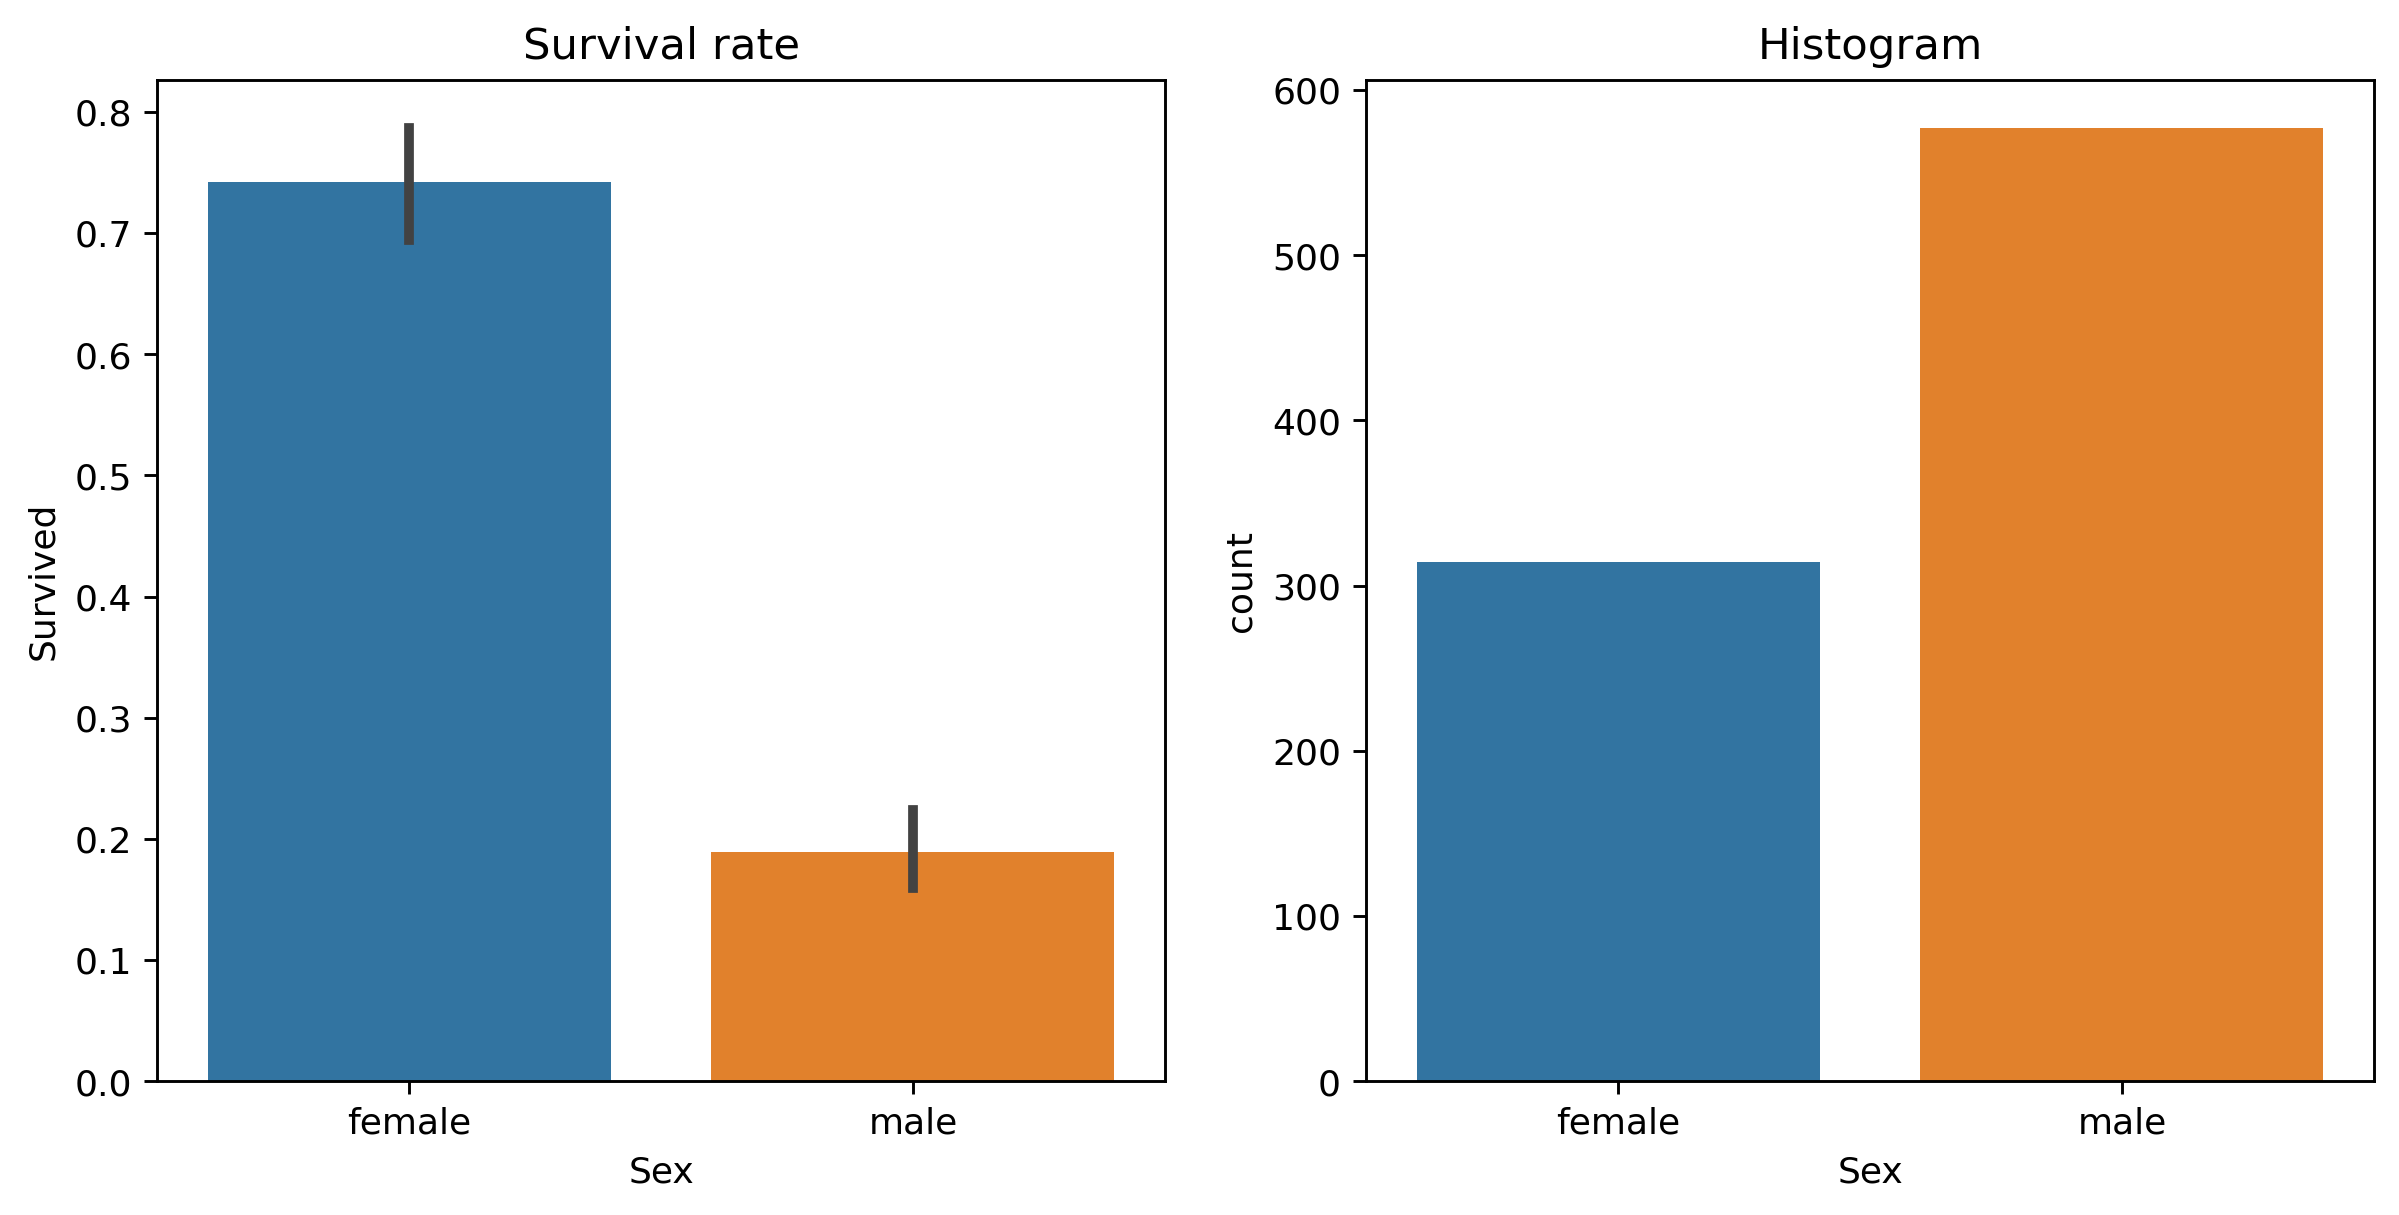

In [ ]:
import seaborn as sns

fig,axs = plt.subplots(1,2, figsize=(11,5),dpi=130)
sns.barplot(data=df, y=dep, x="Sex", ax=axs[0]).set(title="Survival rate")
sns.countplot(data=df, x="Sex", ax=axs[1]).set(title="Histogram");

Using this, we can split our dataset into a training set and a validation set for creating a model that predict if a person survived or no:

Note that we are changing the categorical variables (`Sex` and `Embarked`) for his corresponding codes:

In [ ]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df,val_df = train_test_split(df, test_size=0.25)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)                                            # apply codes for the categorical variables
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)


Now we can crate our independent `x` and dependent `y` variables:

In [ ]:
def xs_y(df):
    xs = df[cats+conts].copy()                                                                      # create a copy with the dependent (categorical and continous) variables
    return xs,df[dep] if dep in df else None                                                        # return both the dependent and independent variables

trn_xs,trn_y = xs_y(trn_df)                                                                         # crete the train and validation sets
val_xs,val_y = xs_y(val_df)

In [ ]:
preds = val_xs.Sex==0

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

0.21524663677130046

if we do the same for continous variables. For example, for the variable of `LogFare`:

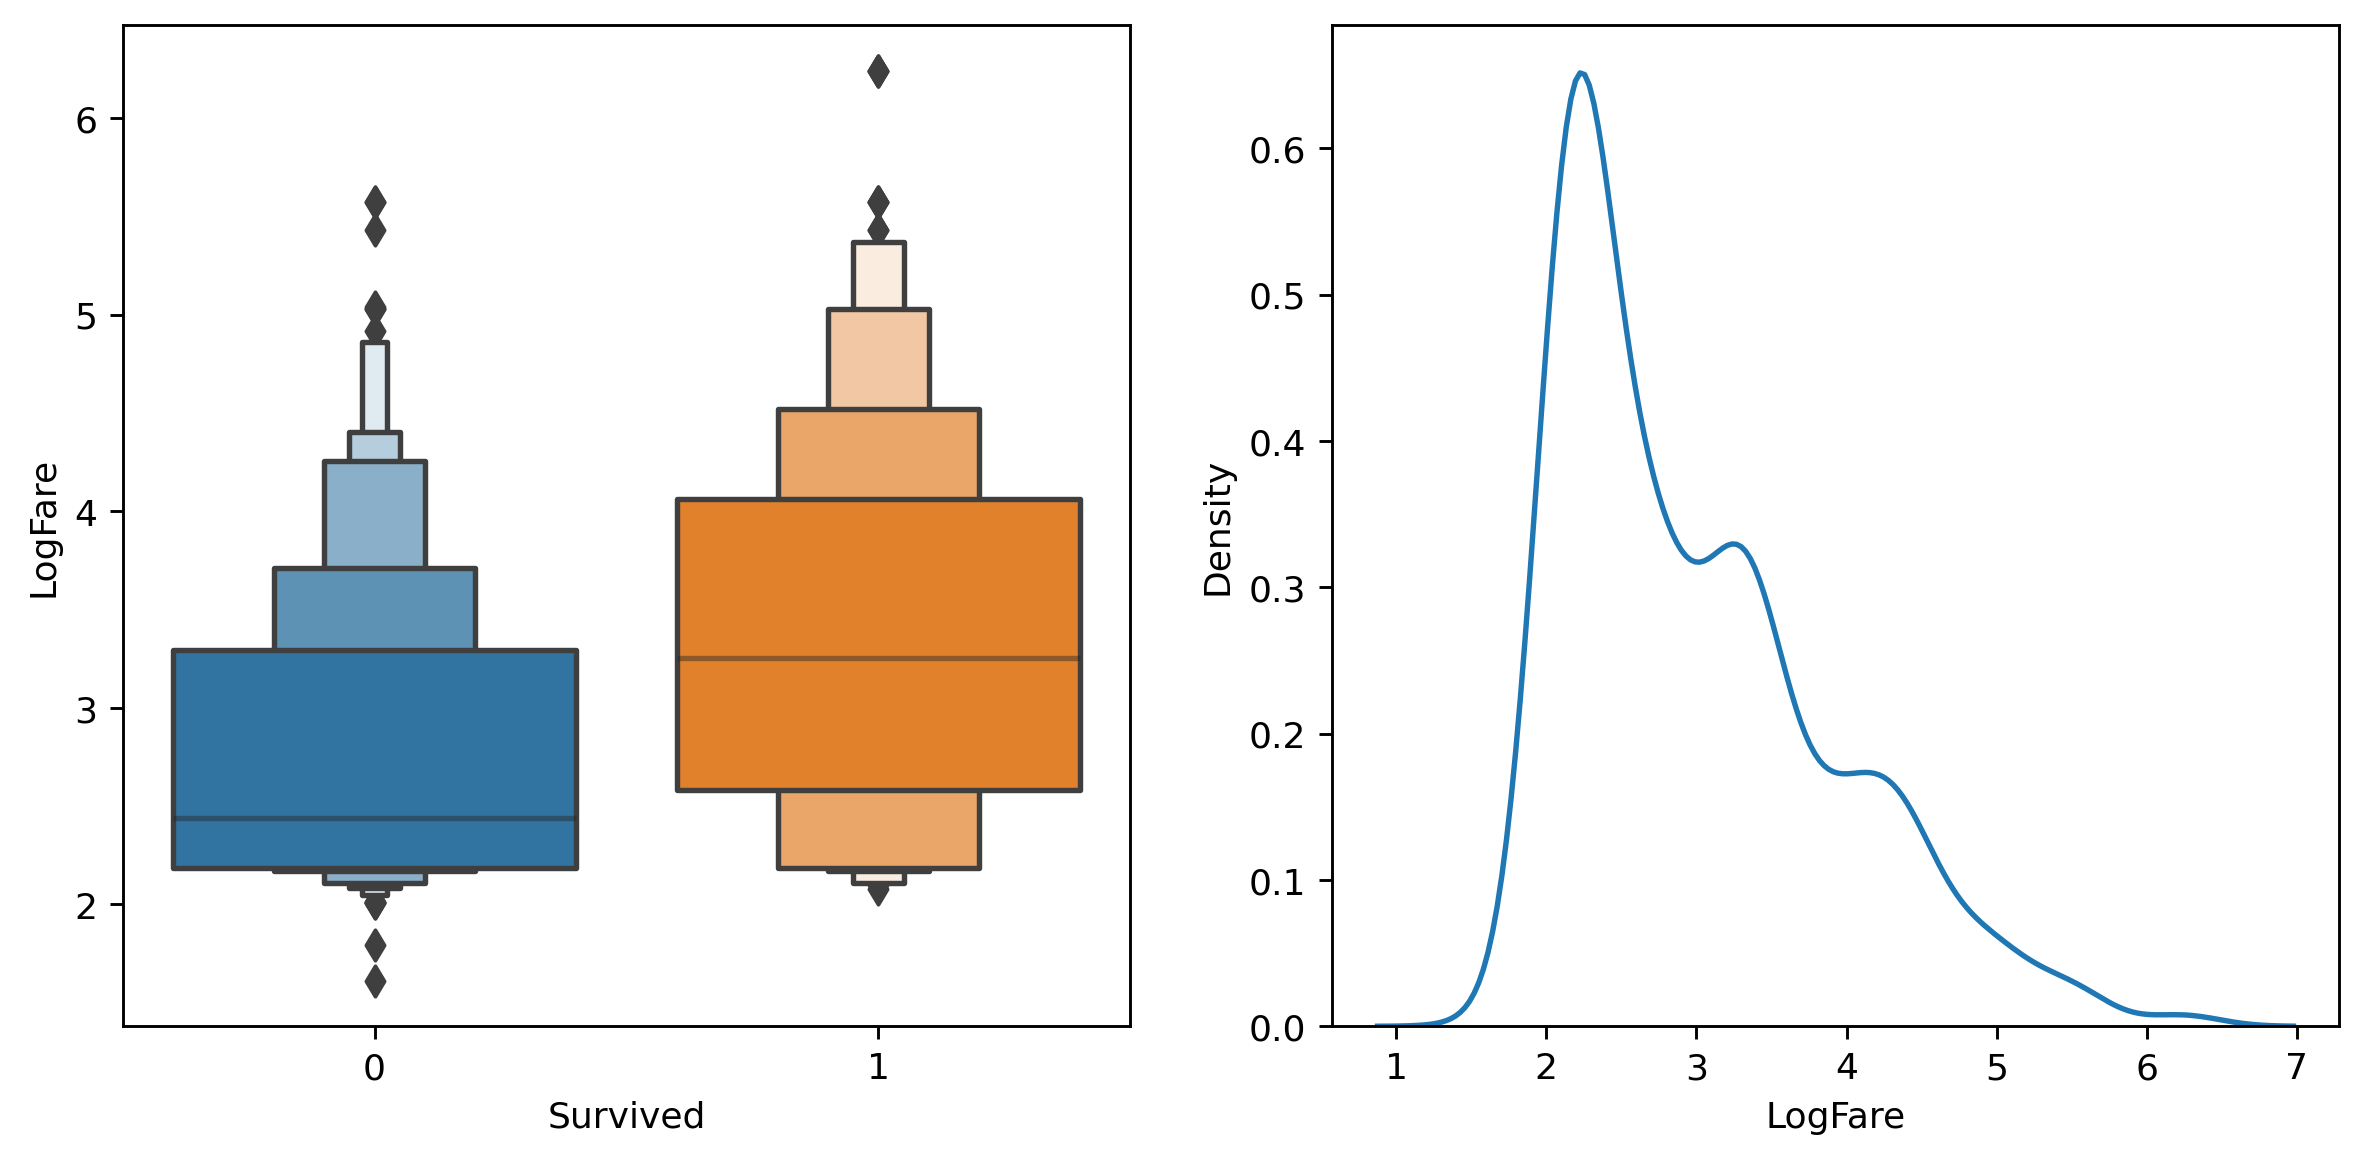

In [ ]:
df_fare = trn_df[trn_df.LogFare>0]
fig,axs = plt.subplots(1,2, figsize=(11,5),dpi=130)
sns.boxenplot(data=df_fare, x=dep, y="LogFare", ax=axs[0])
sns.kdeplot(data=df_fare, x="LogFare", ax=axs[1]);

Set the treshold and calc the _mse_:

In [ ]:
preds = val_xs.LogFare>3
mean_absolute_error(val_y, preds)

0.3094170403587444

For other side, we could create a function that tells us how good our model is, we'll create a `score` function  to do this, this function will calculate the _impurity_, that is, how much the binary split creates two groups where the rows in a group are each similar to each other, or dissmilar.

We can maesure the similarity of rows inside a group by taking the standard deviation of the dependent variable

In [ ]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot

In [ ]:
def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y) # here the ~ symbol means not

In [ ]:
score(trn_xs["Sex"], trn_y, 0.5)

0.40787530982063946

In [ ]:
score(trn_xs["LogFare"], trn_y, 2.7)

0.47180873952099694

In [ ]:
def iscore(nm, split):
    col = trn_xs[nm]
    return score(col, trn_y, split)

from ipywidgets import interact
interact(nm=conts, split=15.5)(iscore);

interactive(children=(Dropdown(description='nm', options=('Age', 'SibSp', 'Parch', 'LogFare', 'Pclass'), value…

In [ ]:
nm = "Age"
col = trn_xs[nm]
unq = col.unique()
unq.sort()
unq

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,  5.  ,  6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  ,
       13.  , 14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 21.  , 22.  , 23.  , 24.  , 24.5 , 25.  , 26.  , 27.  ,
       28.  , 28.5 , 29.  , 30.  , 31.  , 32.  , 32.5 , 33.  , 34.  , 34.5 , 35.  , 36.  , 36.5 , 37.  , 38.  , 39.  , 40.  ,
       40.5 , 41.  , 42.  , 43.  , 44.  , 45.  , 45.5 , 46.  , 47.  , 48.  , 49.  , 50.  , 51.  , 52.  , 53.  , 54.  , 55.  ,
       55.5 , 56.  , 57.  , 58.  , 59.  , 60.  , 61.  , 62.  , 64.  , 65.  , 70.  , 70.5 , 74.  , 80.  ])

In [ ]:
scores = np.array([score(col, trn_y, o) for o in unq if not np.isnan(o)])
unq[scores.argmin()]

6.0

In [ ]:
def min_col(df, nm):
    col,y = df[nm],df[dep]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

min_col(trn_df, "Age")

(6.0, 0.478316717508991)

In [ ]:
cols = cats+conts
{o:min_col(trn_df, o) for o in cols}

{'Sex': (0, 0.40787530982063946),
 'Embarked': (0, 0.47883342573147836),
 'Age': (6.0, 0.478316717508991),
 'SibSp': (4, 0.4783740258817434),
 'Parch': (0, 0.4805296527841601),
 'LogFare': (2.4390808375825834, 0.4620823937736597),
 'Pclass': (2, 0.46048261885806596)}

# creating a decission tree

In [ ]:
cols.remove("Sex")
ismale = trn_df.Sex==1
males,females = trn_df[ismale],trn_df[~ismale]

In [ ]:
{o:min_col(males, o) for o in cols}

{'Embarked': (0, 0.3875581870410906),
 'Age': (6.0, 0.3739828371010595),
 'SibSp': (4, 0.3875864227586273),
 'Parch': (0, 0.3874704821461959),
 'LogFare': (2.803360380906535, 0.3804856231758151),
 'Pclass': (1, 0.38155442004360934)}

In [ ]:
{o:min_col(females, o) for o in cols}

{'Embarked': (0, 0.4295252982857327),
 'Age': (50.0, 0.4225927658431649),
 'SibSp': (4, 0.42319212059713535),
 'Parch': (3, 0.4193314500446158),
 'LogFare': (4.256321678298823, 0.41350598332911376),
 'Pclass': (2, 0.3335388911567601)}

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y);

In [ ]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

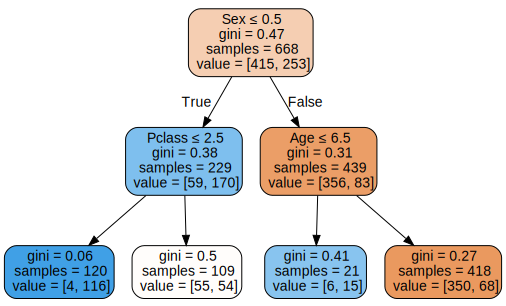

In [ ]:
draw_tree(m, trn_xs, size=10)

In [ ]:
mean_absolute_error(val_y, m.predict(val_xs))

0.2242152466367713

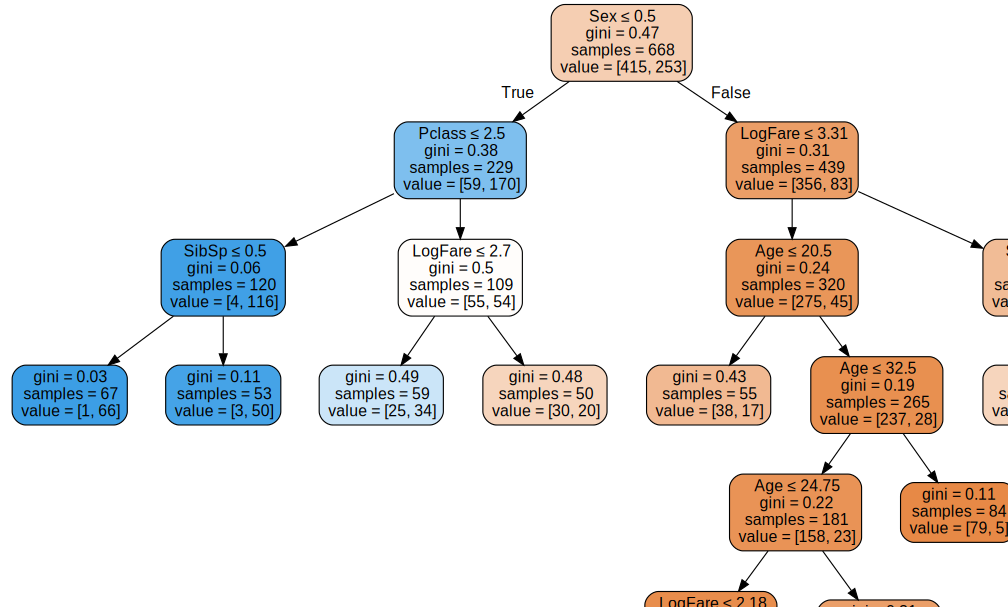

In [ ]:
m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=14)

In [ ]:
mean_absolute_error(val_y, m.predict(val_xs))

0.18385650224215247

## The random forest

In [ ]:
def get_tree(prop=0.75):
    n = len(trn_y)
    idxs = random.choice(n, int(n*prop))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])

In [ ]:
trees = [get_tree() for t in range(100)]

In [ ]:
all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)

mean_absolute_error(val_y, avg_probs)

0.2272645739910314

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf.predict(val_xs))

0.18834080717488788

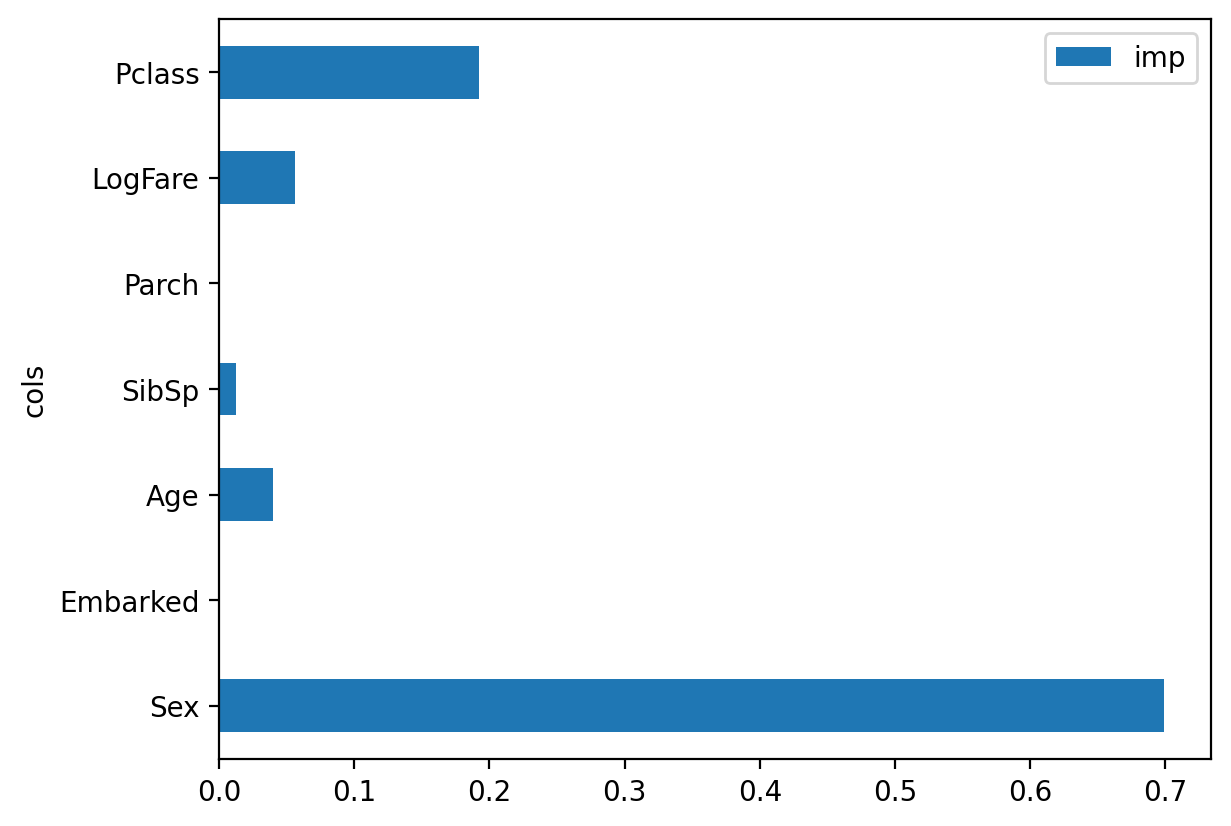

In [ ]:
  pd.DataFrame(dict(cols=trn_xs.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh');

In [ ]:
trn_xs

,Sex,Embarked,Age,SibSp,Parch,LogFare,Pclass
298,1,2,24.00,0,0,3.449988,1
884,1,2,25.00,0,0,2.085672,3
247,0,2,24.00,0,2,2.740840,2
478,1,2,22.00,0,0,2.142510,3
305,1,2,0.92,1,2,5.027492,1
...,...,...,...,...,...,...,...
106,0,2,21.00,0,0,2.157559,3
270,1,2,24.00,0,0,3.465736,1
860,1,2,41.00,2,0,2.715244,3
435,0,2,14.00,1,2,4.795791,1


In [ ]:
trn_y

298    1
884    0
247    1
478    0
305    1
      ..
106    1
270    0
860    0
435    1
102    0
Name: Survived, Length: 668, dtype: int64

In [ ]:
n = len(trn_y)
idxs = random.choice(n, int(n*0.75))
idxs

array([230, 489, 578, 532, 294,  41, 528, 498, 565, 104, 152, 404,  18, 412,  54, 178, 199, 162, 324, 123, 507, 409, 666, 252,
       278, 576, 625, 219, 245, 590,  68, 494, 661, 379,   0, 142,  93,  66, 453,   4, 280, 330,  61, 141, 600, 368, 376, 435,
       538,  51, 232,   0, 388, 191, 615, 100, 225, 379, 503, 428, 370,  17, 526, 509,  32, 243, 266, 540, 519, 541, 585, 574,
       128, 520, 310, 490, 376,   2, 513, 443, 455, 605, 657,  58, 514, 517, 626, 621, 526, 597,  82, 241, 205, 598,  24, 160,
       192, 116, 465, 563, 472, 526, 562, 126, 317, 571, 200,  88, 545, 615, 366, 522, 206, 498, 284, 522, 384, 464, 412, 190,
       570, 491, 602, 291, 654, 606,  59, 270,  33,  15, 288, 125, 604, 479,  31, 399,  78, 539, 141, 215, 376, 610, 158,  21,
        24, 557,  41, 544, 506, 611, 345, 581, 466, 497, 311, 152, 313, 201, 559, 106, 201, 463, 368, 225, 103, 437, 576, 503,
       445, 453, 146, 517, 370, 451, 649, 631, 170, 566, 380, 630, 245, 648, 446, 232, 382, 139, 557, 360,  77,

In [ ]:
int(n*0.75)

501

In [ ]:
n

668

In [ ]:
random.choice(300,400)

array([284, 230, 182,  72,  32, 145, 180, 265,  27,  60, 219, 187,  86, 153,  42,  32, 275,  15, 159, 117,  10, 107, 103, 110,
       153, 118,   0, 229, 267,  72,  94, 211, 146,  95, 118, 286,  21, 120,  75,  82,  65, 259, 157, 150, 276,   6,  75, 104,
       202,  45, 205, 294, 194,  99, 245, 102, 215, 168,  31, 221, 163,  69, 183, 106,  67,  67, 140, 250, 234,  79,  23,  39,
       151, 151, 229, 146, 285,  88, 199, 247, 223, 237, 107, 191, 240,  96, 228, 265, 245, 151, 227, 130,  46, 228,  87, 207,
        52, 207, 271, 259,  23, 238, 158,  87, 250,  87, 159,  78, 230,  11, 272, 232, 105, 240, 152, 246, 281, 195,  28,  78,
       182, 225,  79,  39,   4,  36,  73, 120,  30, 249,  13, 289,  52, 100,  20, 292,  95, 228, 272, 227, 158,  49, 177, 298,
        16, 197, 221, 146, 189,  39,  36,  94, 143,  76,  25, 192, 289, 123, 134, 192, 191, 145, 188, 127, 252, 209,  15, 191,
       285, 232, 125,  91, 137,  74, 118,  69, 284,  21, 299,  62, 177, 124,  19, 107, 142, 132, 270,  10,  32,

In [ ]:
val_xs

,Sex,Embarked,Age,SibSp,Parch,LogFare,Pclass
709,1,0,24.0,1,1,2.787834,3
439,1,2,31.0,0,0,2.442347,2
840,1,2,20.0,0,0,2.188856,3
720,0,2,6.0,0,1,3.526361,2
39,0,0,14.0,1,0,2.504848,3
...,...,...,...,...,...,...,...
880,0,2,25.0,0,1,3.295837,2
425,1,2,24.0,0,0,2.110213,3
101,1,2,24.0,0,0,2.185579,3
199,0,2,24.0,0,0,2.639057,2
